In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

# TensorNetwork class
class TensorNetwork:
    def __init__(self, graph, tensors):
        self.graph = graph
        self.tensors = tensors
        self.index_dims = {}
        self.index_to_tensors = {}

        for name, (tensor, indices) in tensors.items():
            for idx, dim in zip(indices, tensor.shape):
                if idx in self.index_dims:
                    assert self.index_dims[idx] == dim, f"index {idx} has inconsistent dimension"
                else:
                    self.index_dims[idx] = dim
                self.index_to_tensors.setdefault(idx, []).append((name, tensor, indices))
        
        self.col_of = {idx: c for c, idx in enumerate(self.index_dims)}

# evaluate configuration
def evaluate_config(network, configs):
    result = np.ones(len(configs))
    for name, (tensor, inds) in network.tensors.items():
        keys = tuple(configs[:, network.col_of[i]] for i in inds)
        result *= tensor[keys]
    return result

# Glauber update
def update_edge(network, configs, idx, beta=1.0):
    # tensors = network.index_to_tensors[idx]
    # dim = network.index_dims[idx]
    # n_chains = configs.shape[0]
    # probs = np.ones((n_chains, dim))
    # for name, arr, inds in tensors:
    #     slc = []
    #     for i in inds:
    #         if i == idx:
    #             slc.append(slice(None))
    #         else:
    #             col = list(network.index_dims).index(i)
    #             slc.append(configs[:, col])
    #     arr_vals = arr[tuple(slc)].reshape(n_chains, dim)
    #     probs *= arr_vals ** beta
    
    # probs = probs / probs.sum(axis=1, keepdims=True)
    # new_vals = [np.random.choice(dim, p=probs[i]) for i in range(n_chains)]
    # idx_pos = list(network.index_dims).index(idx)
    # configs[:, idx_pos] = new_vals

    dim = network.index_dims[idx]
    col = network.col_of[idx]
    n_chains = configs.shape[0]

    probs = np.ones((n_chains, dim))
    for _, tensor, inds in network.index_to_tensors[idx]:
        slc = []
        for i in inds:
            if i == idx:
                slc.append(slice(None))
            else:
                slc.append(configs[:, network.col_of[i]])
        
        arr_vals = tensor[tuple(slc)]
        if arr_vals.shape != (n_chains, dim):
            arr_vals = arr_vals.T
        probs *= arr_vals ** beta
    
    probs /= probs.sum(axis=1, keepdims=True)
    new_vals = [np.random.choice(dim, p=probs[i]) for i in range(n_chains)]
    configs[:, col] = new_vals


# contraction estimate with live plot
def estimate_contraction(net       : TensorNetwork,
                         betas     : np.ndarray,
                         iters     : int  = 10_000,
                         burns     : int  = 1_000,
                         n_rounds  : int  = 5,
                         verbose   : bool = True):
    logZ_trajs       = [[] for _ in range(n_rounds)]
    weights_by_beta  = [[] for _ in range(len(betas)-1)]
    logZ_sums        = np.zeros(n_rounds)

    index_list = list(net.index_dims)
    total_steps = len(betas) - 1
    dim_size = len(index_list)

    configs = np.random.randint(0, 3, size=(n_rounds, dim_size))

    for i in range(1, len(betas)):
        beta_prev, beta_curr = betas[i-1], betas[i]
        delta_beta = beta_curr - beta_prev

        if verbose and (i % 10 == 0 or i == total_steps):
            timestamp = datetime.now().strftime("%H:%M:%S")
            print(f'[{timestamp}] beta step {i}/{total_steps} ({beta_curr:.4f}) ')

        all_weights = [[] for _ in range(n_rounds)]

        for t in range(iters):
            idx = np.random.choice(index_list)
            update_edge(net, configs, idx, beta=beta_prev)
            if t >= burns:
                psi_vals = evaluate_config(net, configs)
                valid = psi_vals > 1e-30
                weights = np.where(valid, psi_vals ** delta_beta, 0.0)
                for j in range(n_rounds):
                    all_weights[j].append(weights[j])

        mean_weights = [np.mean(w) if len(w) > 0 else 0.0 for w in all_weights]
        log_rhos     = [np.log(mw) if mw > 0 else -np.inf for mw in mean_weights]

        for j in range(n_rounds):
            logZ_sums[j] += log_rhos[j]
            logZ_trajs[j].append(logZ_sums[j])
            weights_by_beta[i-1].append(np.asarray(all_weights[j]))

        if verbose:
            print(f"[beta={beta_curr:.3f}]  mean log rho = {np.mean(log_rhos):+.3e}  | <w> mean = {np.mean(mean_weights):.4e}")

    log_size = np.sum(np.log(list(net.index_dims.values())))
    Z_ests = np.exp(logZ_sums + log_size)
    return Z_ests, logZ_trajs, weights_by_beta


# run several independent AIS chains and visualize convergence
def run_multiple_chains(net        : TensorNetwork,
                        betas      : np.ndarray,
                        n_chains   : int  = 5,
                        iters      : int  = 10_000,
                        burns      : int  = 1_000,
                        n_rounds   : int  = 5,
                        Z_true     : float|None = None,
                        n_workers  : int  = None):

    print(f"Running {n_chains} AIS chains vectorized")
    Z_ests, logZ_trajectories, weights_by_beta = estimate_contraction(
        net, betas, iters, burns, n_rounds=n_chains, verbose=True
    )

    # ---------- 1) cumulative log-Z trajectories ----------------------- #
    plt.figure(figsize=(12, 3.8))
    for k, traj in enumerate(logZ_trajectories, 1):
        plt.plot(betas[1:], traj, label=f"chain {k}", alpha=0.8)
    plt.xlabel(r"$\beta$")
    plt.ylabel(r"$\log Z$ (cumulative.)")
    plt.title("log-Z convergence across chains")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # ---------- 2) relative sigma(w) per beta -------------------------------- #
    plt.figure(figsize=(12, 3.8))
    for k in range(n_chains):
        rel_sig = []
        for weights in weights_by_beta:
            w = weights[k]
            rel = np.std(w) / np.mean(w) if np.mean(w) > 0 else 0
            rel_sig.append(rel)
        plt.plot(betas[1:], rel_sig, label=f"chain {k+1}", alpha=0.8)
    plt.xlabel(r"$\beta$")
    plt.ylabel(r"rel $\sigma(w)$")
    plt.title("weight dispersion vs beta")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # ---------- 3) final-estimate statistics -------------------------- #
    est_mean, est_std = np.mean(Z_ests), np.std(Z_ests)
    rel_var = est_std / est_mean if est_mean > 0 else float("nan")
    print(rf"\nFinal relative variance of $\hat Z$: {rel_var:.4e}")

    if Z_true is not None:
        rel_errs = [abs(z - Z_true)/abs(Z_true) for z in Z_ests]
        plt.figure(figsize=(5.5, 4))
        plt.bar(range(1, n_chains+1), rel_errs)
        plt.xlabel("chain"); plt.ylabel("rel error")
        plt.title("final relative error per chain")
        plt.grid(True); plt.tight_layout(); plt.show()

        print(f"True  Z   : {Z_true:.6f}")
        print(f"Mean  Ẑ  : {est_mean:.6f}  ± {est_std:.6f}")
        print(f"Mean rel error: {np.mean(rel_errs):.2%}")

    return est_mean, est_std

In [ ]:
# test on 2x2 ring tensor network: Tr(ABCD)
def test_trace_ABCD(dim=3,
                    betas=np.linspace(0, 1, 100),
                    n_chains=5,
                    iters=20000,
                    burns=1900,
                    n_rounds=5):
    print("\n>>> Building 2x2 ring tensor network (Tr(ABCD))")

    # create 2x2 ring tensor network
    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'), ('B', 'C'),
        ('C', 'D'), ('D', 'A'),
    ])

    # positive tensors with shape (dim, dim)
    A, B, C, D = [np.random.rand(dim, dim) + 1e-6 for _ in range(4)]
    tensors = {
        'A': (A, ['i', 'j']),
        'B': (B, ['j', 'k']),
        'C': (C, ['k', 'l']),
        'D': (D, ['l', 'i'])
    }

    # exact contraction: trace of product
    TRUE_Z = np.einsum('ij,jk,kl,li->', A, B, C, D)
    print(f"True Z (Tr(ABCD)): {TRUE_Z:.6f}")

    tn = TensorNetwork(G, tensors)

    print("\n>>> Running MCMC chains")
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        n_rounds=n_chains,
        Z_true=TRUE_Z
    )

    rel_error = abs(mean_Z - TRUE_Z) / abs(TRUE_Z)
    print("\n================== Final Summary ==================")
    print(f"True       Z : {TRUE_Z:.6f}")
    print(f"Estimated  Z : {mean_Z:.6f} ± {std_Z:.6f}")
    print(f"Relative Error: {rel_error:.2e}")
    print("====================================================")

test_trace_ABCD()


>>> Building 3x3 tensor network
True Z (exact contraction): 531622.424690

>>> Running MCMC chains
Running 5 AIS chains vectorized
[beta=0.000]  mean log rho = -3.683e-09  | <w> mean = 1.0000e+00
[beta=0.000]  mean log rho = -3.590e-08  | <w> mean = 1.0000e+00
[beta=0.000]  mean log rho = -4.899e-08  | <w> mean = 1.0000e+00
[beta=0.000]  mean log rho = -3.479e-08  | <w> mean = 1.0000e+00
[beta=0.001]  mean log rho = -7.885e-08  | <w> mean = 1.0000e+00
[beta=0.001]  mean log rho = +5.511e-08  | <w> mean = 1.0000e+00
[beta=0.001]  mean log rho = +3.498e-08  | <w> mean = 1.0000e+00
[beta=0.002]  mean log rho = +2.236e-07  | <w> mean = 1.0000e+00
[beta=0.002]  mean log rho = -2.385e-07  | <w> mean = 1.0000e+00
[18:08:46] beta step 10/199 (0.0025) 
[beta=0.003]  mean log rho = -1.313e-08  | <w> mean = 1.0000e+00
[beta=0.003]  mean log rho = -3.759e-07  | <w> mean = 1.0000e+00
[beta=0.004]  mean log rho = -6.430e-08  | <w> mean = 1.0000e+00
[beta=0.004]  mean log rho = -5.296e-07  | <w> mea

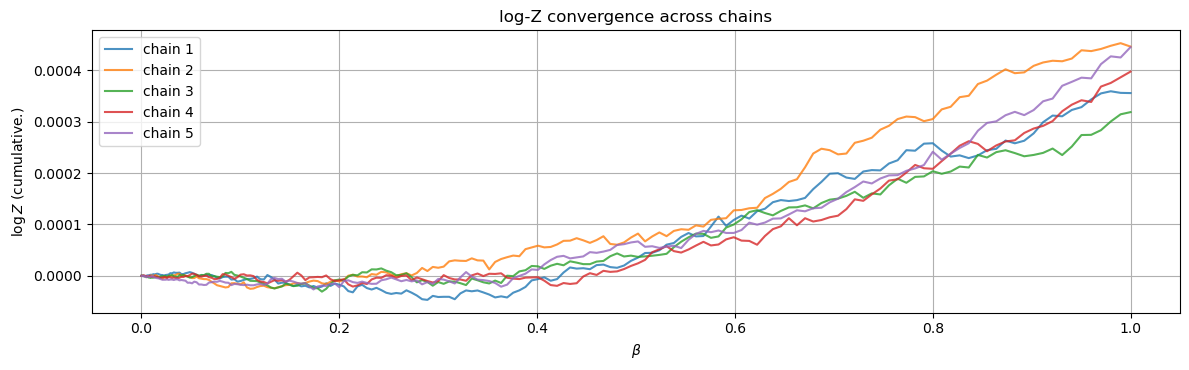

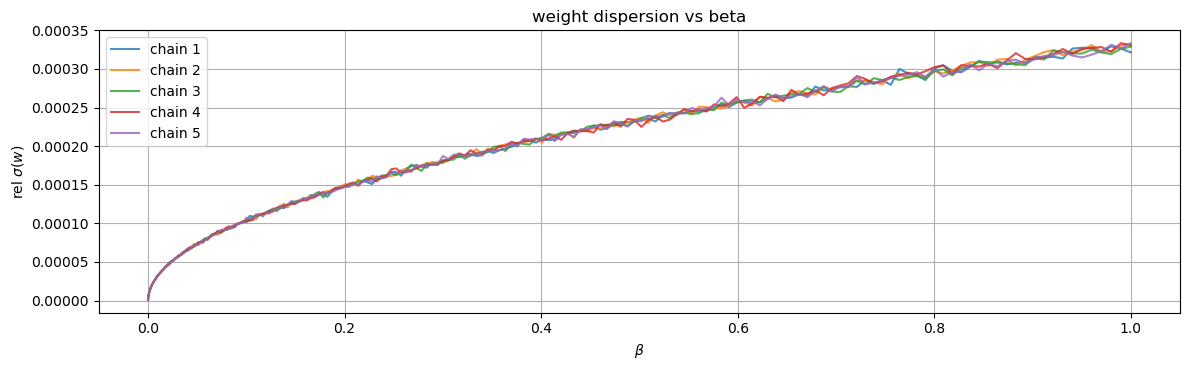

\nFinal relative variance of $\hat Z$: 4.9959e-05


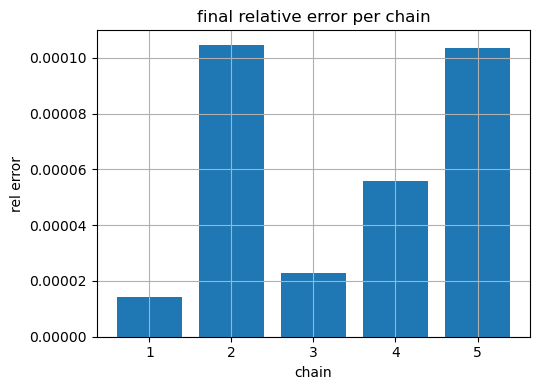

True  Z   : 531622.424690
Mean  Ẑ  : 531649.597992  ± 26.560507
Mean rel error: 0.01%

================== Final Summary ==================
True       Z : 531622.424690
Estimated  Z : 531649.597992 ± 26.560507
Relative Error: 5.11e-05


In [4]:
# contract full tensor network using np.einsum
def contract_tensor_network(graph, tensors):
    """
    Efficient full contraction using einsum.
    tensors: dict[node_name] = (ndarray, [str indices])
    """
    einsum_terms = []
    einsum_tensors = []
    index_map = {}
    chars = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')
    for _, (tensor, indices) in tensors.items():
        subs = []
        for idx in indices:
            if idx not in index_map:
                if not chars:
                    raise ValueError("not enough characters for indices")
                index_map[idx] = chars.pop(0)
            subs.append(index_map[idx])
        einsum_terms.append(''.join(subs))
        einsum_tensors.append(tensor)
    
    einsum_expr = ','.join(einsum_terms) + '->'
    return np.einsum(einsum_expr, *einsum_tensors)

# build 3x3 grid tensor network
def build_3x3_grid_test(dim=3):
    G = nx.Graph()
    tensors = {}
    grid_size = 3
    node_names = {(i, j): f"T{i}{j}" for i in range(grid_size) for j in range(grid_size)}

    def edge_index(i1, j1, i2, j2):
        return f"{i1}{j1}_{i2}{j2}"

    for i in range(grid_size):
        for j in range(grid_size):
            name = node_names[(i, j)]
            neighbors = []

            if j + 1 < grid_size:
                nbr = node_names[(i, j+1)]
                idx = edge_index(i, j, i, j+1)
                G.add_edge(name, nbr)
                neighbors.append(idx)

            if i + 1 < grid_size:
                nbr = node_names[(i+1, j)]
                idx = edge_index(i, j, i+1, j)
                G.add_edge(name, nbr)
                neighbors.append(idx)

            if j > 0:
                neighbors.append(edge_index(i, j-1, i, j))
            if i > 0:
                neighbors.append(edge_index(i-1, j, i, j))
            variance = 0.01
            neighbors = sorted(neighbors)
            shape = (dim,) * len(neighbors)
            data = np.abs(np.random.normal(1.0, variance, size=shape)) + 1e-6  
            tensors[name] = (data, neighbors)

    return G, tensors

# full test on 3x3 grid tensor network with summary
def test_trace_3x3_grid(dim=3,
                        betas=np.linspace(0, 1, 200)**2,
                        n_chains=5,
                        iters=20000,
                        burns=2000,
                        n_rounds=50):
    print("\n>>> Building 3x3 tensor network")
    G, tensors = build_3x3_grid_test(dim=dim)
    TRUE_Z = contract_tensor_network(G, tensors)
    print(f"True Z (exact contraction): {TRUE_Z:.6f}")

    tn = TensorNetwork(G, tensors)

    print("\n>>> Running MCMC chains")
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        n_rounds=n_rounds,
        Z_true=TRUE_Z
    )

    rel_error = abs(mean_Z - TRUE_Z) / TRUE_Z
    print("\n================== Final Summary ==================")
    print(f"True       Z : {TRUE_Z:.6f}")
    print(f"Estimated  Z : {mean_Z:.6f} ± {std_Z:.6f}")
    print(f"Relative Error: {rel_error:.2e}")
    print("====================================================")

test_trace_3x3_grid()